In [23]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from numpy import asarray
from sklearn.model_selection import RepeatedKFold
from numpy import mean
from numpy import std
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

In [24]:
columns = ['CLOC', 'LC', 'MLOC', 'LM', 'LMC', 'LMCS', 'LPLPAR', 'LPL', 'NOC', 'LLFPAR', 'NOO', 'LLF']
df = pd.read_csv('code_smell_dataset.csv', usecols=columns)
df

,CLOC,LC,MLOC,LM,LMC,LMCS,LPLPAR,LPL,NOC,LLFPAR,NOO,LLF
0,38.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,42.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,44.0,1.0,34.0,0.0,2.0,0.0,13.0,1.0,0.0,0.0,0.0,0.0
3,44.0,1.0,34.0,0.0,2.0,0.0,6.0,1.0,0.0,0.0,0.0,0.0
4,44.0,1.0,34.0,0.0,2.0,0.0,13.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
375525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0,1.0,7.0,0.0
375526,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0,0.0,2.0,0.0
375527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.0,2.0,5.0,0.0
375528,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0,0.0,4.0,0.0


In [25]:
# seperating data and labels 
X = df.drop(columns=['LC', 'LM', 'LMCS', 'LPL', 'LLF'], axis=1)
Y = df.drop(columns=['CLOC', 'MLOC', 'LMC', 'LPLPAR', 'NOC', 'LLFPAR', 'NOO'], axis=1)
print(X.head())
print(Y.head())

   CLOC  MLOC  LMC  LPLPAR  NOC  LLFPAR  NOO
0  38.0   0.0  0.0     0.0  0.0     0.0  0.0
1  42.0   0.0  0.0     0.0  0.0     0.0  0.0
2  44.0  34.0  2.0    13.0  0.0     0.0  0.0
3  44.0  34.0  2.0     6.0  0.0     0.0  0.0
4  44.0  34.0  2.0    13.0  0.0     0.0  0.0
    LC   LM  LMCS  LPL  LLF
0  1.0  0.0   0.0  0.0  0.0
1  1.0  0.0   0.0  0.0  0.0
2  1.0  0.0   0.0  1.0  0.0
3  1.0  0.0   0.0  1.0  0.0
4  1.0  0.0   0.0  1.0  0.0


In [26]:
# Handling Outliers
def handle_outliers(df, IQR, variable):
    lower_bridge = df[variable].quantile(0.25) - (IQR*1.5)
    upper_bridge = df[variable].quantile(0.75) + (IQR*1.5)
    
    df.loc[df[variable] >= upper_bridge, variable] = upper_bridge
    df.loc[df[variable] <= lower_bridge, variable] = lower_bridge

IQR_CLOC = df['CLOC'].quantile(0.75) - df['CLOC'].quantile(0.25)
IQR_MLOC = df['MLOC'].quantile(0.75) - df['MLOC'].quantile(0.25)
IQR_LMC = df['LMC'].quantile(0.75) - df['LMC'].quantile(0.25)
IQR_LPLPAR = df['LPLPAR'].quantile(0.75) - df['LPLPAR'].quantile(0.25)
IQR_NOC = df['NOC'].quantile(0.75) - df['NOC'].quantile(0.25)
IQR_LLFPAR = df['LLFPAR'].quantile(0.75) - df['LLFPAR'].quantile(0.25)
IQR_NOO = df['NOO'].quantile(0.75) - df['NOO'].quantile(0.25)

handle_outliers(X, IQR_CLOC, 'CLOC')
handle_outliers(X, IQR_MLOC, 'MLOC')
handle_outliers(X, IQR_LMC, 'LMC')
handle_outliers(X, IQR_LPLPAR, 'LPLPAR')
handle_outliers(X, IQR_NOC, 'NOC')
handle_outliers(X, IQR_LLFPAR, 'LLFPAR')
handle_outliers(X, IQR_NOO, 'NOO')

In [41]:
# train test split 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [42]:
# scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

/var/folders/n1/j4qhhn297tj4tnrpbsvg4q800000gn/T/ipykernel_2387/2404590566.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


Text(0.5, 1.0, 'X_train After Scaling')

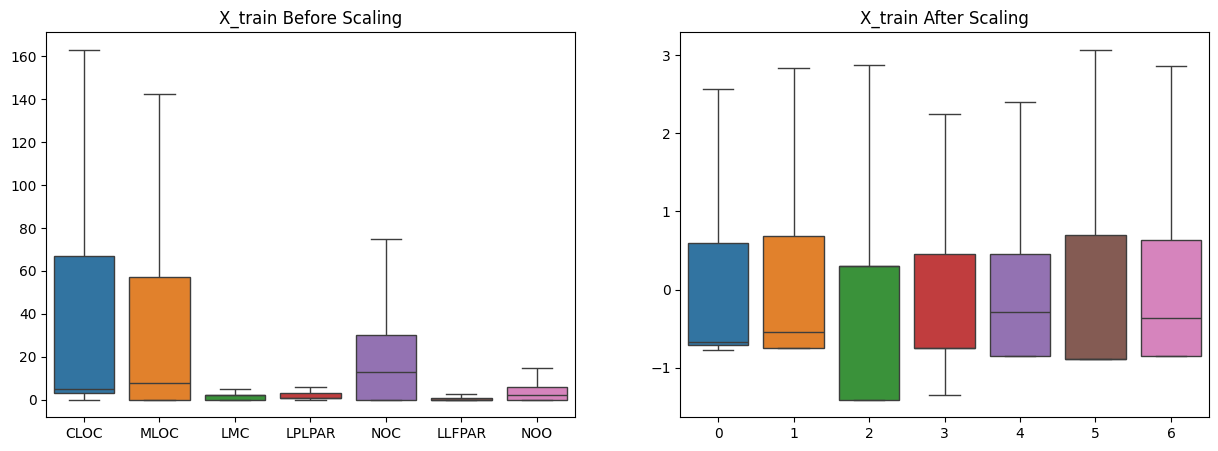

In [43]:
# Visualize the effect of scaling
plt.subplots(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.boxplot(data=X_train)
plt.title('X_train Before Scaling')
plt.subplot(1, 2, 2)
sns.boxplot(data=X_train_scaled)
plt.savefig("scaling.png")
plt.title('X_train After Scaling')

In [48]:
# Assuming y is your target variable
classes = np.unique(Y)
print(Y)
# Compute class weights
class_weights = compute_class_weight('balanced', classes=classes, y=Y)
class_weight_dict = dict(enumerate(class_weights))

         LC   LM  LMCS  LPL  LLF
0       1.0  0.0   0.0  0.0  0.0
1       1.0  0.0   0.0  0.0  0.0
2       1.0  0.0   0.0  1.0  0.0
3       1.0  0.0   0.0  1.0  0.0
4       1.0  0.0   0.0  1.0  0.0
...     ...  ...   ...  ...  ...
375525  0.0  0.0   0.0  0.0  0.0
375526  0.0  0.0   0.0  0.0  0.0
375527  0.0  0.0   0.0  0.0  0.0
375528  0.0  0.0   0.0  0.0  0.0
375529  0.0  0.0   0.0  0.0  0.0

[375530 rows x 5 columns]


ValueError: classes should include all valid labels that can be in y

In [44]:
# Create, train, fit and evaluate model
model = Sequential()
model.add(Dense(64, input_dim=7, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(5, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train_scaled, Y_train, epochs=100, batch_size=16, validation_data=(X_test_scaled, Y_test))

loss, accuracy = model.evaluate(X_test_scaled, Y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

Epoch 1/100
18777/18777 [==============================] - 7s 383us/step - loss: 0.0069 - accuracy: 0.5463 - val_loss: 7.1436e-04 - val_accuracy: 0.5313
Epoch 2/100
18777/18777 [==============================] - 7s 382us/step - loss: 8.0337e-04 - accuracy: 0.5237 - val_loss: 0.0039 - val_accuracy: 0.5131
Epoch 3/100
18777/18777 [==============================] - 7s 385us/step - loss: 6.3964e-04 - accuracy: 0.5170 - val_loss: 7.4975e-04 - val_accuracy: 0.4940
Epoch 4/100
 1505/18777 [=>............................] - ETA: 5s - loss: 6.7282e-04 - accuracy: 0.5000

KeyboardInterrupt: 

In [39]:
# Make predictions on new data
new_data = np.array([[100, 100, 6, 7, 148, 7, 19]])
new_data_scaled = scaler.transform(new_data)
predictions = model.predict(new_data_scaled)

print(f'Predicted Labels: {predictions}')

1/1 [==============================] - 0s 27ms/step
Predicted Labels: [[0.0000000e+00 0.0000000e+00 3.4812862e-12 9.9999255e-01 9.9997306e-01]]


/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
